# Nicholson's blowflies

Contributed by Sean L. Wu [@slwu89](https://github.com/slwu89).

Nicholson’s blowflies are a classic example of a time-delayed stage-structured population model, and was presented as a case study in the [sPop paper](https://f1000research.com/articles/7-1220). We reproduce that example here using Population.jl.

The model comprises five distinct life-stages and exhibits stable quasi-cyclic oscillations. Although the model was originally constructed using delay differential equations, Population.jl adheres well to the observed dynamics despite the discrete time step. We demonstrate both deterministic and stochastic versions of the basic dynamical model.

In [1]:
using Pkg
Pkg.activate("/Users/kamil/Projects/github/Population.jl")

  Activating project at `~/Projects/github/Population.jl`


In [2]:
using Population
using Plots
using Distributions
using Statistics

First we define parameters of the model.

In [3]:
# Define daily propensity of death
death = [0.07, 0.004, 0.003, 0.0025, 0.27]

# Define the expected duration of development (in days)
develop = [0.6, 5.0, 5.9, 4.1, Inf]

# Define the rest of the parameters
A0 = 600.0
q = 8.5
tau = 24
# tau is a scaling factor to extend from daily to hourly iterations for more accurracy

24

Next we define a function to run the simulation for 300 days, in either stochastic or deterministic mode. The 5 life stages are stored in the vector `vec`. Each life stage has an `AgeConst` process for simulating mortality, which is independent of age in the blowflies model. It also has an `AgeFixed` process to simulate maturation, which has a deterministic (fixed) distribution in the blowflies model. Therefore variation in the stochastic version arises from the mortality process and egg laying, which is assumed to be drawn from a Poisson distribution centered on the deterministic mean.

On each day we calculate the terms required for the mortality and development processes (`pr1` and `pr2`). Then we use `StepPop` to iterate the population for one day, and we store the output containing the total population size, dictionary of individuals completing development, and dictionary of all developing individuals for that stage in the vector `out`. Then we pass individuals who have completed development to the next stage life stage. Finally we compute the number of eggs produced by adults and add them to the egg stage.

In [4]:
# this function is a wrapper routine to simulate a deterministic or a stochastic time series
function sim_blowfly(stoch)
    output = zeros(300*tau+1, 5)
    # initiate 5 stages of the population and store them in a vector
    vec = [stoch ? sPop2(PopDataSto()) : sPop2(PopDataDet()) for n in 1:5]
    [AddProcess(v, AgeConst(), AgeFixed()) for v in vec]
    # add individuals to the initial stage (the egg stage)
    AddPop(vec[1], stoch ? 500 : 500.0)
    # record the initial conditions
    output[1, :] = [GetPop(v) for v in vec]
    # vector to store the output each day
    out = Vector{Any}(nothing, length(vec))
    # iterate for 300 days
    for n in 1:300*tau        
        # for each stage, repeat the following
        for m in 1:length(vec)
            # iterate the stage for one time unit
            pr1 = (prob = death[m]/tau,)
            pr2 = (devmn = develop[m]*tau,)
            out[m] = StepPop(vec[m], pr1, pr2)
            # and pass on to the next stage (if not the adult stage)
            if m > one(m)
                for (q,s) in out[m-1][3][2]
                    AddPop(vec[m], s, 0.0, 0.0)
                end
            end
        end
        # calculate the number of eggs to produce
        eggs = q * GetPop(vec[5]) * exp(-GetPop(vec[5])/A0)/tau
        if stoch
            eggs = rand(Poisson(eggs))
        end
        AddPop(vec[1], eggs)
        # record the current state
        output[n+1, :] = [GetPop(v) for v in vec]
    end
    # return the results
    return output
end

sim_blowfly (generic function with 1 method)

We run the deterministic model, and sample 100 trajectories from the stochastic model. For the stochastic plots we show the median as a solid line and the upper and lower boundaries of the 95% quantiles as dashed lines. We plot results from the last 200 days of simulation.

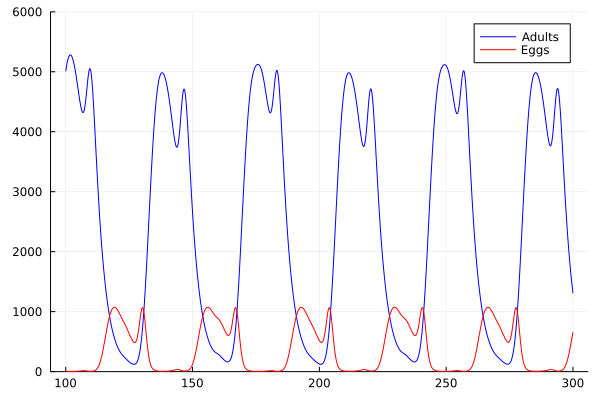

In [5]:
out = sim_blowfly(false)

xtick = 100:(1/tau):300
plot(xtick, out[100*tau+1:end,5], label = "Adults", color = :blue, ylim = [0,6000])
plot!(xtick, out[100*tau+1:end,1], label = "Eggs", color = :red)

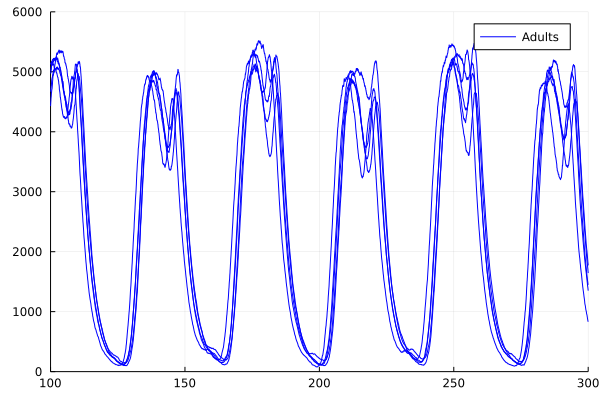

In [8]:
xtick = 100:(1/tau):300
plot((100,300),(0,6000), linestyle=:none)
for n in 1:5
    out = sim_blowfly(true)
    plot!(xtick, out[100*tau+1:end,5], linestyle = :solid, label = n == 1 ? "Adults" : :none, color = :blue, ylim = [0,6000])
end
display(xlims!(100,300))

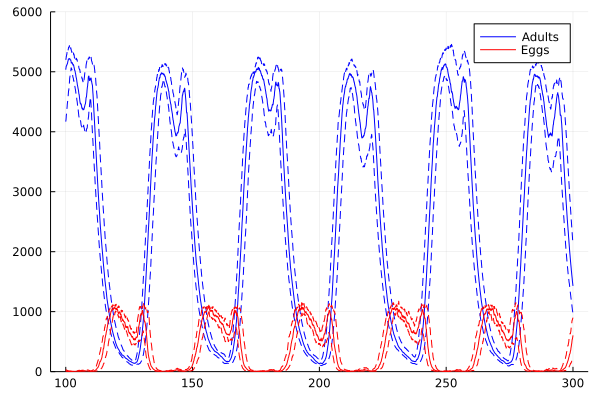

In [9]:
outs = [sim_blowfly(true) for n in 1:10]
outs = cat(outs..., dims=3)

outs_adult_qt = [quantile(outs[i,5,:], [0.025, 0.5, 0.975]) for i in axes(outs,1)]
outs_adult_qt = transpose(hcat(outs_adult_qt...))

outs_eggs_qt = [quantile(outs[i,1,:], [0.025, 0.5, 0.975]) for i in axes(outs,1)]
outs_eggs_qt = transpose(hcat(outs_eggs_qt...))

plot(xtick, outs_adult_qt[100*tau+1:end,2], linestyle = :solid, label = "Adults", color = :blue, ylim = [0,6000])
plot!(xtick, outs_adult_qt[100*tau+1:end,3], linestyle = :dash, label = false, color = :blue)
plot!(xtick, outs_adult_qt[100*tau+1:end,1], linestyle = :dash, label = false, color = :blue)

plot!(xtick, outs_eggs_qt[100*tau+1:end,2], linestyle = :solid, label = "Eggs", color = :red)
plot!(xtick, outs_eggs_qt[100*tau+1:end,3], linestyle = :dash, label = false, color = :red)
plot!(xtick, outs_eggs_qt[100*tau+1:end,1], linestyle = :dash, label = false, color = :red)